In [ ]:
from google.colab import auth
auth.authenticate_user()
print("✅ Authenticated with Google account")

✅ Authenticated with Google account


In [ ]:

from google.colab import auth
auth.authenticate_user()
print("Authenticated successfully with your Google account.")

from google.cloud import bigquery
import pandas as pd
import os
import re

PROJECT_ID = "even-blueprint-441418-p2"
DATASET_ID = "media_analytics"


csv_files = {
    "staging_aggregated_country": "/content/Aggregated_Metrics_By_Country_And_Subscriber_Status.csv",
    "staging_aggregated_video": "/content/Aggregated_Metrics_By_Video.csv",
    "staging_all_comments": "/content/All_Comments_Final.csv",
    "staging_video_performance": "/content/Video_Performance_Over_Time.csv"
}

#Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# Clean column names
def clean_column_names(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=True)
        .str.replace(r"[^\w_]", "", regex=True)
    )
    return df

# Clean malformed CSV
def clean_csv_quotes(file_path):
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        cleaned_lines = []
        for line in lines:
            line = line.replace('"', "'")
            line = line.replace(",,", ", ,")
            cleaned_lines.append(line)

        temp_file = "/tmp/cleaned_" + os.path.basename(file_path)
        with open(temp_file, "w", encoding="utf-8") as f:
            f.writelines(cleaned_lines)
        print(f"Cleaned CSV → {temp_file}")
        return temp_file
    except Exception as e:
        print(f"Warning: Error cleaning {file_path}: {e}")
        return file_path

#  Upload to Staging
def upload_to_staging():
    for table_name, file_path in csv_files.items():
        print(f"\nProcessing {file_path} → {table_name} ...")

        # Clean comments file
        if "comments" in table_name.lower():
            print("Cleaning comments CSV...")
            file_path = clean_csv_quotes(file_path)

        # Load CSV
        try:
            df = pd.read_csv(
                file_path,
                encoding="utf-8",
                engine="python",
                on_bad_lines="skip",
                dtype=str
            )
            print(f"Loaded {len(df):,} rows, {len(df.columns)} cols")
        except Exception as e:
            print(f"Failed to read CSV: {e}")
            continue

        if df.empty:
            print("Empty DataFrame. Skipping.")
            continue

        # Clean columns
        df = clean_column_names(df)

        # Drop nulls in first column
        first_col = df.columns[0]
        before = len(df)
        df = df.dropna(subset=[first_col])
        print(f"Dropped {before - len(df):,} rows with null '{first_col}'")

        # Build table ID
        table_id = f"{PROJECT_ID}.{DATASET_ID}.{table_name}"
        if not re.match(r'^[a-zA-Z0-9_-]+\.[a-zA-Z0-9_-]+\.[a-zA-Z0-9_-]+$', table_id):
            print(f"Invalid table_id: {table_id}")
            continue

        print(f"Uploading → {table_id}")

        # Load job
        job_config = bigquery.LoadJobConfig(
            write_disposition="WRITE_TRUNCATE",
            autodetect=True,
            skip_leading_rows=1,
            source_format=bigquery.SourceFormat.CSV,
            allow_quoted_newlines=True,
            allow_jagged_rows=True
        )

        try:
            job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
            job.result()
            table = client.get_table(table_id)
            print(f"SUCCESS: {len(df):,} rows → {table_id} (Total rows: {table.num_rows:,})")
        except Exception as e:
            print(f"Upload FAILED: {e}")
            print("Sample data:")
            print(df.head(2).to_string())

# RUN
if __name__ == "__main__":
    print("\nStarting ETL for Media Content Analytics Platform...")
    upload_to_staging()
    print("\nETL COMPLETED!")

Authenticated successfully with your Google account.

Starting ETL for Media Content Analytics Platform...

Processing /content/Aggregated_Metrics_By_Country_And_Subscriber_Status.csv → staging_aggregated_country ...
Loaded 55,292 rows, 15 cols
Dropped 0 rows with null 'video_title'
Uploading → even-blueprint-441418-p2.media_analytics.staging_aggregated_country
SUCCESS: 55,292 rows → even-blueprint-441418-p2.media_analytics.staging_aggregated_country (Total rows: 55,291)

Processing /content/Aggregated_Metrics_By_Video.csv → staging_aggregated_video ...
Loaded 224 rows, 19 cols
Dropped 0 rows with null 'video'
Uploading → even-blueprint-441418-p2.media_analytics.staging_aggregated_video
SUCCESS: 224 rows → even-blueprint-441418-p2.media_analytics.staging_aggregated_video (Total rows: 223)

Processing /content/All_Comments_Final.csv → staging_all_comments ...
Cleaning comments CSV...
Cleaned CSV → /tmp/cleaned_All_Comments_Final.csv
Loaded 11,385 rows, 7 cols
Dropped 1 rows with null 'c

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project="even-blueprint-441418-p2")
DATASET_ID = "media_analytics"
GOLD_DATASET = f"{PROJECT_ID}.{DATASET_ID}"

# DELETE CONFLICTING TABLES
print("Deleting conflicting Gold tables...")
for table in ["gold_country_metrics", "gold_comments_clean", "gold_creator_dashboard"]:
    try:
        client.delete_table(f"{PROJECT_ID}.{DATASET_ID}.{table}")
        print(f"Deleted {table}")
    except:
        print(f"{table} not found or already deleted")

# === STEP 2: RECREATE UDF (ENSURE IT EXISTS) ===
client.query('''
CREATE OR REPLACE FUNCTION `even-blueprint-441418-p2.media_analytics.parse_duration`(d STRING)
RETURNS INT64
LANGUAGE js AS
"""
  if (!d || d.trim() === '') return 0;
  const parts = d.split(':').map(Number);
  if (parts.length === 3) return parts[0]*3600 + parts[1]*60 + parts[2];
  if (parts.length === 2) return parts[0]*60 + parts[1];
  return parts[0] || 0;
"""
''').result()
print("UDF parse_duration() ready")

#STEP 3: FINAL GOLD TABLES (SAFE_CAST, NO DOT, MATCH CLUSTERING)
GOLD_TABLES = {
    "gold_video_metrics": f"""
        SELECT
            video AS video_id,
            video_title,
            SAFE.PARSE_TIMESTAMP('%b %d, %Y', video_publish_time) AS video_publish_date,
            CAST(views AS INT64) AS views,
            CAST(watch_time_hours AS FLOAT64) AS watch_time_hours,
            CAST(average_percentage_viewed_ AS FLOAT64) AS avg_view_percentage,
            `even-blueprint-441418-p2.media_analytics.parse_duration`(average_view_duration) AS avg_view_duration_seconds,
            CAST(likes AS INT64) AS likes,
            CAST(dislikes AS INT64) AS dislikes,
            CAST(shares AS INT64) AS shares,
            CAST(comments_added AS INT64) AS comments_added,
            CAST(subscribers_gained AS INT64) AS subscribers_gained,
            CAST(subscribers_lost AS INT64) AS subscribers_lost,
            CAST(subscribers AS INT64) AS total_subscribers,
            CAST(rpm_usd AS FLOAT64) AS rpm_usd,
            CAST(cpm_usd AS FLOAT64) AS cpm_usd,
            CAST(your_estimated_revenue_usd AS FLOAT64) AS estimated_revenue_usd,
            CAST(impressions AS INT64) AS impressions,
            CAST(impressions_clickthrough_rate_ AS FLOAT64) AS click_through_rate_pct
        FROM `{GOLD_DATASET}.staging_aggregated_video`
        WHERE video IS NOT NULL
    """,

    "gold_country_metrics": f"""
        SELECT
            external_video_id AS video_id,
            country_code,
            LOWER(is_subscribed) = 'true' AS is_subscribed,
            SAFE_CAST(views AS INT64) AS views,
            SAFE_CAST(average_view_percentage AS FLOAT64) AS avg_view_percentage,
            SAFE_CAST(average_watch_time AS FLOAT64) AS avg_watch_time_seconds,
            SAFE_CAST(video_likes_added AS INT64) AS likes_added,
            SAFE_CAST(video_dislikes_added AS INT64) AS dislikes_added,
            SAFE_CAST(video_likes_removed AS INT64) AS likes_removed,
            SAFE_CAST(user_subscriptions_added AS INT64) AS subs_added,
            SAFE_CAST(user_subscriptions_removed AS INT64) AS subs_removed,
            SAFE_CAST(user_comments_added AS INT64) AS comments_added
        FROM `{GOLD_DATASET}.staging_aggregated_country`
        WHERE external_video_id IS NOT NULL
          AND country_code IS NOT NULL
    """,

    "gold_comments_clean": f"""
        SELECT
            comment_id,
            vidid AS video_id,
            comments AS comment_text,
            SAFE.PARSE_DATE('%Y-%m-%d', SUBSTR(date, 1, 10)) AS comment_date,
            SAFE_CAST(reply_count AS INT64) AS reply_count,
            SAFE_CAST(like_count AS INT64) AS like_count,
            CASE
                WHEN LOWER(comments) LIKE '%http%' THEN TRUE
                WHEN LENGTH(comments) < 3 THEN TRUE
                ELSE FALSE
            END AS is_spam_suspected
        FROM `{GOLD_DATASET}.staging_all_comments`
        WHERE comment_id IS NOT NULL
          AND comments IS NOT NULL
          AND TRIM(comments) != ''
    """,

    "gold_creator_dashboard": f"""
        WITH video_base AS (
            SELECT
                video AS video_id,
                video_title,
                SAFE.PARSE_TIMESTAMP('%b %d, %Y', video_publish_time) AS video_publish_date,
                CAST(views AS INT64) AS total_views,
                CAST(watch_time_hours AS FLOAT64) AS watch_time_hours,
                CAST(average_percentage_viewed_ AS FLOAT64) AS avg_view_percentage,
                CAST(your_estimated_revenue_usd AS FLOAT64) AS revenue_usd
            FROM `{GOLD_DATASET}.staging_aggregated_video`
        ),
        country_agg AS (
            SELECT
                external_video_id AS video_id,
                SUM(CASE WHEN LOWER(is_subscribed) = 'true' THEN SAFE_CAST(views AS INT64) ELSE 0 END) AS subscriber_views,
                SUM(CASE WHEN LOWER(is_subscribed) = 'false' THEN SAFE_CAST(views AS INT64) ELSE 0 END) AS non_subscriber_views
            FROM `{GOLD_DATASET}.staging_aggregated_country`
            GROUP BY external_video_id
        ),
        comment_agg AS (
            SELECT
                vidid AS video_id,
                COUNT(*) AS total_comments
            FROM `{GOLD_DATASET}.staging_all_comments`
            WHERE comments IS NOT NULL AND TRIM(comments) != ''
            GROUP BY vidid
        )
        SELECT
            v.video_id,
            v.video_title,
            v.video_publish_date,
            v.total_views,
            v.watch_time_hours,
            ROUND(v.watch_time_hours * 60, 2) AS watch_time_minutes,
            v.avg_view_percentage,
            v.revenue_usd,
            COALESCE(c.total_comments, 0) AS total_comments,
            COALESCE(ca.subscriber_views, 0) AS subscriber_views,
            COALESCE(ca.non_subscriber_views, 0) AS non_subscriber_views
        FROM video_base v
        LEFT JOIN country_agg ca ON v.video_id = ca.video_id
        LEFT JOIN comment_agg c ON v.video_id = c.video_id
    """
}

# CONFIG: Match existing clustering or remove
TABLE_CONFIGS = {
    "gold_video_metrics": {"partition": "video_publish_date", "cluster": ["video_id"]},
    "gold_country_metrics": {"partition": None, "cluster": ["video_id", "countrY_code"]},  # Match old
    "gold_comments_clean": {"partition": "comment_date", "cluster": ["video_id"]},
    "gold_creator_dashboard": {"partition": None, "cluster": None}
}

# BUILD GOLD
def create_gold():
    print("\nBUILDING GOLD LAYER (FINAL)...\n")
    for name, sql in GOLD_TABLES.items():
        table_id = f"{PROJECT_ID}.{DATASET_ID}.{name}"
        config = TABLE_CONFIGS.get(name, {})

        job_config = bigquery.QueryJobConfig(
            destination=table_id,
            write_disposition="WRITE_TRUNCATE",
            clustering_fields=config.get("cluster"),
            time_partitioning=bigquery.TimePartitioning(
                type_=bigquery.TimePartitioningType.DAY,
                field=config.get("partition")
            ) if config.get("partition") else None
        )

        print(f"→ {name}")
        try:
            job = client.query(sql, job_config=job_config)
            job.result()
            rows = client.get_table(table_id).num_rows
            print(f"   {rows:,} rows")
        except Exception as e:
            print(f"   FAILED: {e}")

create_gold()
print("\nGOLD LAYER 100% COMPLETE!")

#  SAMPLE DATA
print("\nSAMPLE DATA")
for t in GOLD_TABLES:
    try:
        df = client.query(f"SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.{t}` LIMIT 2").to_dataframe()
        print(f"\n{t.upper()}:")
        print(df.to_string(index=False))
    except Exception as e:
        print(f"{t}: {e}")

Deleting conflicting Gold tables...
Deleted gold_country_metrics
Deleted gold_comments_clean
Deleted gold_creator_dashboard
UDF parse_duration() ready

BUILDING GOLD LAYER (FINAL)...

→ gold_video_metrics
   223 rows
→ gold_country_metrics
   54,905 rows
→ gold_comments_clean
   8,252 rows
→ gold_creator_dashboard
   223 rows

GOLD LAYER 100% COMPLETE!

SAMPLE DATA

GOLD_VIDEO_METRICS:
   video_id                                                               video_title        video_publish_date  views  watch_time_hours  avg_view_percentage  avg_view_duration_seconds  likes  dislikes  shares  comments_added  subscribers_gained  subscribers_lost  total_subscribers  rpm_usd  cpm_usd  estimated_revenue_usd  impressions  click_through_rate_pct
rdo8YBasqqA Reviewing Your Data Science Projects - Episode 13 (BONUS LinkedIn Review) 2020-07-27 00:00:00+00:00   5106          316.0491                30.52                        222    248         2      37              50                  36     

In [ ]:

from google.cloud import bigquery
import textwrap

# === CONFIG ===
PROJECT_ID = "even-blueprint-441418-p2"
DATASET_ID = "media_analytics"
FULL_DATASET = f"{PROJECT_ID}.{DATASET_ID}"
client = bigquery.Client(project=PROJECT_ID)

# === UDF: Parse HH:MM:SS → seconds ===
client.query(textwrap.dedent('''
    CREATE OR REPLACE FUNCTION `even-blueprint-441418-p2.media_analytics.parse_duration`(d STRING)
    RETURNS INT64
    LANGUAGE js AS
    """
      if (!d || d.trim() === '') return 0;
      const parts = d.split(':').map(Number);
      if (parts.length === 3) return parts[0]*3600 + parts[1]*60 + parts[2];
      if (parts.length === 2) return parts[0]*60 + parts[1];
      return parts[0] || 0;
    """
''')).result()

LAYERS = {

    # BRONZE LAYER

    "bronze_aggregated_video": {
        "sql": f"""
            SELECT
              video AS video_id,
              video_title,
              SAFE.PARSE_TIMESTAMP('%b %d, %Y', video_publish_time) AS video_publish_date,
              SAFE_CAST(views AS INT64) AS views,
              SAFE_CAST(watch_time_hours AS FLOAT64) AS watch_time_hours,
              SAFE_CAST(average_percentage_viewed_ AS FLOAT64) AS avg_view_percentage,
              `even-blueprint-441418-p2.media_analytics.parse_duration`(average_view_duration) AS avg_view_duration_seconds,
              SAFE_CAST(likes AS INT64) AS likes,
              SAFE_CAST(dislikes AS INT64) AS dislikes,
              SAFE_CAST(shares AS INT64) AS shares,
              SAFE_CAST(comments_added AS INT64) AS comments_added,
              SAFE_CAST(subscribers_gained AS INT64) AS subscribers_gained,
              SAFE_CAST(subscribers_lost AS INT64) AS subscribers_lost,
              SAFE_CAST(subscribers AS INT64) AS total_subscribers,
              SAFE_CAST(rpm_usd AS FLOAT64) AS rpm_usd,
              SAFE_CAST(cpm_usd AS FLOAT64) AS cpm_usd,
              SAFE_CAST(your_estimated_revenue_usd AS FLOAT64) AS estimated_revenue_usd,
              SAFE_CAST(impressions AS INT64) AS impressions,
              SAFE_CAST(impressions_clickthrough_rate_ AS FLOAT64) AS click_through_rate_pct
            FROM `{FULL_DATASET}.staging_aggregated_video`
            WHERE video IS NOT NULL
        """,
        "partition": "video_publish_date",
        "cluster": ["video_id"]
    },

    "bronze_country_metrics": {
        "sql": f"""
            SELECT
              external_video_id AS video_id,
              country_code,
              LOWER(is_subscribed) = 'true' AS is_subscribed,
              SAFE_CAST(views AS INT64) AS views,
              SAFE_CAST(average_view_percentage AS FLOAT64) AS avg_view_percentage,
              SAFE_CAST(average_watch_time AS FLOAT64) AS avg_watch_time_seconds,
              SAFE_CAST(video_likes_added AS INT64) AS likes_added,
              SAFE_CAST(video_dislikes_added AS INT64) AS dislikes_added,
              SAFE_CAST(video_likes_removed AS INT64) AS likes_removed,
              SAFE_CAST(user_subscriptions_added AS INT64) AS subs_added,
              SAFE_CAST(user_subscriptions_removed AS INT64) AS subs_removed,
              SAFE_CAST(user_comments_added AS INT64) AS comments_added
            FROM `{FULL_DATASET}.staging_aggregated_country`
            WHERE external_video_id IS NOT NULL
        """,
        "partition": None,
        "cluster": ["video_id", "country_code"]
    },

    "bronze_comments": {
        "sql": f"""
            SELECT
              comment_id,
              vidid AS video_id,
              comments AS comment_text,
              SAFE.PARSE_DATE('%Y-%m-%d', SUBSTR(date, 1, 10)) AS comment_date,
              SAFE_CAST(reply_count AS INT64) AS reply_count,
              SAFE_CAST(like_count AS INT64) AS like_count
            FROM `{FULL_DATASET}.staging_all_comments`
            WHERE comment_id IS NOT NULL
              AND comments IS NOT NULL
              AND TRIM(comments) != ''
        """,
        "partition": "comment_date",
        "cluster": ["video_id"]
    },


    # SILVER LAYER

    "silver_video_enriched": {
        "sql": f"""
            WITH video AS (
              SELECT * FROM `{FULL_DATASET}.bronze_aggregated_video`
            ),
            country AS (
              SELECT
                video_id,
                SUM(CASE WHEN is_subscribed THEN views ELSE 0 END) AS subscriber_views,
                SUM(CASE WHEN NOT is_subscribed THEN views ELSE 0 END) AS non_subscriber_views
              FROM `{FULL_DATASET}.bronze_country_metrics`
              GROUP BY video_id
            ),
            comments AS (
              SELECT video_id, COUNT(*) AS total_comments
              FROM `{FULL_DATASET}.bronze_comments`
              GROUP BY video_id
            )
            SELECT
              v.*,
              COALESCE(c.subscriber_views, 0) AS subscriber_views,
              COALESCE(c.non_subscriber_views, 0) AS non_subscriber_views,
              COALESCE(cm.total_comments, 0) AS total_comments,
              ROUND(v.watch_time_hours * 60, 2) AS watch_time_minutes,
              SAFE_DIVIDE(c.subscriber_views, NULLIF(c.subscriber_views + c.non_subscriber_views, 0)) AS subscriber_view_pct
            FROM video v
            LEFT JOIN country c ON v.video_id = c.video_id
            LEFT JOIN comments cm ON v.video_id = cm.video_id
        """,
        "partition": "video_publish_date",
        "cluster": ["video_id"]
    },

    "silver_comments_clean": {
        "sql": f"""
            SELECT
              *,
              CASE
                WHEN LOWER(comment_text) LIKE '%http%' THEN TRUE
                WHEN LENGTH(comment_text) < 3 THEN TRUE
                ELSE FALSE
              END AS is_spam_suspected
            FROM `{FULL_DATASET}.bronze_comments`
        """,
        "partition": "comment_date",
        "cluster": ["video_id"]
    },

    # GOLD LAYER

    "gold_video_metrics": {
        "sql": f"SELECT * FROM `{FULL_DATASET}.bronze_aggregated_video`",
        "partition": "video_publish_date",
        "cluster": ["video_id"]
    },

    "gold_country_metrics": {
        "sql": f"SELECT * FROM `{FULL_DATASET}.bronze_country_metrics`",
        "partition": None,
        "cluster": ["video_id", "country_code"]
    },

    "gold_comments_clean": {
        "sql": f"SELECT * FROM `{FULL_DATASET}.silver_comments_clean`",
        "partition": "comment_date",
        "cluster": ["video_id"]
    },

    "gold_creator_dashboard": {
        "sql": f"""
            SELECT
              video_id,
              video_title,
              video_publish_date,
              views AS total_views,
              watch_time_hours,
              watch_time_minutes,
              avg_view_percentage,
              estimated_revenue_usd AS revenue_usd,
              total_comments,
              subscriber_views,
              non_subscriber_views,
              subscriber_view_pct
            FROM `{FULL_DATASET}.silver_video_enriched`
            ORDER BY total_views DESC
        """,
        "partition": None,
        "cluster": None
    }
}

# BUILD ALL LAYERS
def build_layers():
    print("BUILDING BRONZE → SILVER → GOLD...\n")
    for table_name, config in LAYERS.items():
        table_id = f"{FULL_DATASET}.{table_name}"
        sql = config["sql"]

        job_config = bigquery.QueryJobConfig(
            destination=table_id,
            write_disposition="WRITE_TRUNCATE",
            clustering_fields=config.get("cluster"),
            time_partitioning=bigquery.TimePartitioning(
                type_=bigquery.TimePartitioningType.DAY,
                field=config.get("partition")
            ) if config.get("partition") else None
        )

        print(f"→ {table_name}")
        try:
            job = client.query(sql, job_config=job_config)
            job.result()
            rows = client.get_table(table_id).num_rows
            print(f"   {rows:,} rows")
        except Exception as e:
            print(f"   FAILED: {e}")
            print(sql[:500])

build_layers()
print("\nALL LAYERS BUILT: BRONZE → SILVER → GOLD")

# SAMPLE DATA
print("\nSAMPLE DATA")
for table in ["bronze_aggregated_video", "silver_video_enriched", "gold_creator_dashboard"]:
    try:
        df = client.query(f"SELECT * FROM `{FULL_DATASET}.{table}` LIMIT 2").to_dataframe()
        print(f"\n{table.upper()}:")
        print(df.to_string(index=False))
    except Exception as e:
        print(f"{table}: {e}")

BUILDING BRONZE → SILVER → GOLD...

→ bronze_aggregated_video
   223 rows
→ bronze_country_metrics
   55,291 rows
→ bronze_comments
   8,252 rows
→ silver_video_enriched
   223 rows
→ silver_comments_clean
   8,252 rows
→ gold_video_metrics
   223 rows
→ gold_country_metrics
   55,291 rows
→ gold_comments_clean
   8,252 rows
→ gold_creator_dashboard
   223 rows

ALL LAYERS BUILT: BRONZE → SILVER → GOLD

SAMPLE DATA

BRONZE_AGGREGATED_VIDEO:
   video_id                                 video_title        video_publish_date  views  watch_time_hours  avg_view_percentage  avg_view_duration_seconds  likes  dislikes  shares  comments_added  subscribers_gained  subscribers_lost  total_subscribers  rpm_usd  cpm_usd  estimated_revenue_usd  impressions  click_through_rate_pct
5SjK6YCs4o4  The Data Science Interview: What to Expect 2019-12-30 00:00:00+00:00   6185          585.3392                38.45                        340    321         1      22              15                  59         

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("✅ Authenticated")


✅ Authenticated


In [ ]:

# MEDIA ANALYTICS ETL


import os
import textwrap
from datetime import datetime, timezone
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# INSTALL
print("Installing packages...")
!pip install --quiet google-cloud-bigquery pandas matplotlib
from google.cloud import bigquery

# --- CONFIG ---
PROJECT_ID = os.getenv("PROJECT_ID", "even-blueprint-441418-p2")
DATASET_ID = os.getenv("DATASET_ID", "media_analytics")
FULL_DATASET = f"{PROJECT_ID}.{DATASET_ID}"

try:
    client = bigquery.Client(project=PROJECT_ID)
    print(f"Connected to BigQuery: {PROJECT_ID}")
except Exception as e:
    print("Upload service account JSON:")
    print("from google.colab import files; uploaded = files.upload(); os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = list(uploaded)[0]")
    raise e

# --- CSVs ---
CSV_FILES = {
    "staging_aggregated_country": "/content/Aggregated_Metrics_By_Country_And_Subscriber_Status.csv",
    "staging_aggregated_video":   "/content/Aggregated_Metrics_By_Video.csv",
    "staging_all_comments":       "/content/All_Comments_Final.csv",
    "staging_video_performance":  "/content/Video_Performance_Over_Time.csv"
}

print("\nChecking CSVs...")
missing = [n for n, p in CSV_FILES.items() if not os.path.exists(p)]
if missing:
    print("Upload missing files:")
    print("from google.colab import files; uploaded = files.upload()")
    raise FileNotFoundError(f"Missing: {', '.join(missing)}")
print("All CSVs found!")


def run_query(sql, job_config=None):
    print("Running query...")
    job = client.query(sql, job_config=job_config)
    job.result()

    dml_rows = getattr(job, 'num_dml_affected_rows', None)
    total_rows = getattr(job, 'total_rows', None)

    if dml_rows is not None:
        rows = dml_rows
    elif total_rows is not None:
        rows = total_rows
    else:
        rows = "N/A"

    print(f"Done. Rows affected: {rows}")
    return job

# --- UDF ---
def ensure_parse_duration_udf():
    print("Creating UDF...")
    sql = textwrap.dedent(f"""
    CREATE OR REPLACE FUNCTION `{PROJECT_ID}.{DATASET_ID}.parse_duration`(d STRING)
    RETURNS INT64 LANGUAGE js AS \"\"\"
      if (!d || d.trim() === '') return 0;
      const parts = d.split(':').map(Number);
      if (parts.length === 3) return parts[0]*3600 + parts[1]*60 + parts[2];
      if (parts.length === 2) return parts[0]*60 + parts[1];
      return parts[0] || 0;
    \"\"\";
    """)
    run_query(sql)

# DQ TABLE
def ensure_dq_table():
    print("Ensuring dq_results...")
    run_query(f"""
    CREATE TABLE IF NOT EXISTS `{FULL_DATASET}.dq_results` (
      run_ts TIMESTAMP,
      check_name STRING,
      status STRING,
      rows_affected INT64,
      message STRING
    );
    """)

# STAGING
def load_csv_to_staging(t, p):
    tgt = f"{FULL_DATASET}.{t}"
    print(f"Loading {os.path.basename(p)} → {tgt}")
    df = pd.read_csv(p, encoding="utf-8", engine="python", on_bad_lines="skip", dtype=str)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_", regex=True).str.replace(r"[^\w_]", "", regex=True)
    df[df.columns[0]] = df[df.columns[0]].str.strip()
    df = df.dropna(subset=[df.columns[0]])
    job = client.load_table_from_dataframe(df, tgt,
        job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", autodetect=True))
    job.result()
    print(f"Loaded {len(df):,} rows")

def load_all_staging():
    print("Loading staging...")
    for t, p in CSV_FILES.items():
        load_csv_to_staging(t, p)

# --- BRONZE ---
def build_bronze():
    print("Building Bronze...")
    run_query(f"DROP TABLE IF EXISTS `{FULL_DATASET}.bronze_aggregated_video`;")
    sql = f"""
    CREATE TABLE `{FULL_DATASET}.bronze_aggregated_video`
    PARTITION BY DATE(video_publish_date)
    CLUSTER BY video_id
    AS
    SELECT
      video AS video_id,
      video_title,
      SAFE.PARSE_TIMESTAMP('%b %d, %Y', video_publish_time) AS video_publish_date,
      SAFE_CAST(views AS INT64) AS views,
      SAFE_CAST(watch_time_hours AS FLOAT64) AS watch_time_hours,
      `{PROJECT_ID}.{DATASET_ID}.parse_duration`(average_view_duration) AS avg_view_duration_seconds,
      SAFE_CAST(average_percentage_viewed_ AS FLOAT64) AS avg_view_percentage,
      SAFE_CAST(likes AS INT64) AS likes,
      SAFE_CAST(comments_added AS INT64) AS comments_added,
      SAFE_CAST(your_estimated_revenue_usd AS FLOAT64) AS estimated_revenue_usd
    FROM `{FULL_DATASET}.staging_aggregated_video`
    WHERE video IS NOT NULL AND video_title IS NOT NULL;
    """
    run_query(sql)
    print("Bronze ready")

# --- SCD2: dim_video ---
def scd2_upsert_dim_video():
    print("SCD2: Recreating dim_video...")
    run_query(f"DROP TABLE IF EXISTS `{FULL_DATASET}.dim_video`;")
    run_query(f"""
    CREATE TABLE `{FULL_DATASET}.dim_video` (
      surrogate_key STRING,
      video_id STRING,
      video_title STRING,
      duration_seconds INT64,
      published_date DATE,
      effective_from TIMESTAMP,
      effective_to TIMESTAMP,
      is_current BOOL,
      source_system STRING
    );
    """)

    print("Running SCD2 MERGE...")
    sql = f"""
    MERGE `{FULL_DATASET}.dim_video` T
    USING (
      SELECT
        video_id,
        video_title,
        DATE(video_publish_date) AS published_date,
        avg_view_duration_seconds AS duration_seconds
      FROM `{FULL_DATASET}.bronze_aggregated_video`
    ) S
    ON T.video_id = S.video_id AND T.is_current = TRUE
    WHEN MATCHED AND (T.video_title IS DISTINCT FROM S.video_title) THEN
      UPDATE SET is_current = FALSE, effective_to = CURRENT_TIMESTAMP()
    WHEN NOT MATCHED THEN
      INSERT (surrogate_key, video_id, video_title, published_date, duration_seconds,
              effective_from, is_current, source_system)
      VALUES (GENERATE_UUID(), S.video_id, S.video_title, S.published_date, S.duration_seconds,
              CURRENT_TIMESTAMP(), TRUE, 'bronze');
    """
    run_query(sql)
    print("SCD2 complete!")

# --- SILVER ---
def build_silver():
    print("Building Silver layer...")
    run_query(f"DROP TABLE IF EXISTS `{FULL_DATASET}.silver_video_enriched`;")
    sql = f"""
    CREATE TABLE `{FULL_DATASET}.silver_video_enriched`
    PARTITION BY DATE(video_publish_date)
    CLUSTER BY video_id
    AS
    SELECT
      d.surrogate_key AS video_surrogate_key,
      b.video_id, b.video_title, b.video_publish_date,
      b.views, b.watch_time_hours,
      ROUND(b.watch_time_hours * 60, 2) AS watch_time_minutes,
      b.avg_view_duration_seconds, b.avg_view_percentage,
      b.likes, b.comments_added, b.estimated_revenue_usd
    FROM `{FULL_DATASET}.bronze_aggregated_video` b
    LEFT JOIN `{FULL_DATASET}.dim_video` d
      ON b.video_id = d.video_id AND d.is_current = TRUE;
    """
    run_query(sql)
    print("Silver layer created (partitioned)")

# --- GOLD ---
def build_gold():
    print("Building Gold...")
    run_query(f"DROP TABLE IF EXISTS `{FULL_DATASET}.gold_creator_dashboard`;")
    sql = f"""
    CREATE TABLE `{FULL_DATASET}.gold_creator_dashboard` AS
    SELECT
      video_surrogate_key, video_id, video_title,
      SUM(views) AS total_views,
      SUM(watch_time_minutes) AS total_watch_minutes,
      AVG(avg_view_percentage) AS avg_view_percentage,
      SUM(estimated_revenue_usd) AS total_revenue_usd,
      SUM(likes) AS total_likes,
      SUM(comments_added) AS total_comments
    FROM `{FULL_DATASET}.silver_video_enriched`
    GROUP BY 1,2,3
    ORDER BY total_views DESC;
    """
    run_query(sql)


DQ_CHECKS = {
    "null_video_id": f"SELECT COUNT(*) FROM `{FULL_DATASET}.bronze_aggregated_video` WHERE video_id IS NULL;",
    "dim_current_unique": f"SELECT video_id, COUNT(*) c FROM `{FULL_DATASET}.dim_video` WHERE is_current=TRUE GROUP BY 1 HAVING c>1;"
}


# data quality checks
def run_data_quality_checks():
    print("Running DQ...")
    for n, q in DQ_CHECKS.items():
        df = client.query(q).to_dataframe()
        cnt = int(df.iloc[0,0]) if not df.empty and len(df) > 0 else 0
        status = "PASS" if cnt == 0 else "FAIL"

        client.insert_rows_json(f"{FULL_DATASET}.dq_results", [{
            "run_ts": datetime.now(timezone.utc).isoformat(),
            "check_name": n,
            "status": status,
            "rows_affected": cnt,
            "message": ""
        }])
        print(f"  • {n}: {status} ({cnt})")

# RUN ALL
def run_all():

    print("STARTING ETL PIPELINE")

    ensure_parse_duration_udf()
    ensure_dq_table()
    load_all_staging()
    build_bronze()
    scd2_upsert_dim_video()
    build_silver()
    build_gold()
    run_data_quality_checks()
    print("PIPELINE COMPLETE!")



run_all()

Installing packages...
Connected to BigQuery: even-blueprint-441418-p2

Checking CSVs...
All CSVs found!
STARTING ETL PIPELINE
Creating UDF...
Running query...
Done. Rows affected: N/A
Ensuring dq_results...
Running query...
Done. Rows affected: N/A
Loading staging...
Loading Aggregated_Metrics_By_Country_And_Subscriber_Status.csv → even-blueprint-441418-p2.media_analytics.staging_aggregated_country
Loaded 55,292 rows
Loading Aggregated_Metrics_By_Video.csv → even-blueprint-441418-p2.media_analytics.staging_aggregated_video
Loaded 224 rows
Loading All_Comments_Final.csv → even-blueprint-441418-p2.media_analytics.staging_all_comments
Loaded 10,239 rows
Loading Video_Performance_Over_Time.csv → even-blueprint-441418-p2.media_analytics.staging_video_performance
Loaded 111,857 rows
Building Bronze...
Running query...
Done. Rows affected: N/A
Running query...
Done. Rows affected: N/A
Bronze ready
SCD2: Recreating dim_video...
Running query...
Done. Rows affected: N/A
Running query...
Done. 

In [ ]:
def scd2_upsert_dim_video():
    print("Running SCD2 MERGE → preserving history...")

    merge_query = f"""
    -- STEP 1: Expire old versions when title changed
    MERGE `{FULL_DATASET}.dim_video` T
    USING (
      SELECT
        video AS video_id,
        video_title
      FROM `{FULL_DATASET}.staging_aggregated_video`
      GROUP BY video, video_title
    ) S
    ON T.video_id = S.video_id
   AND T.is_current = TRUE
   AND T.video_title != S.video_title

    WHEN MATCHED THEN
      UPDATE SET
        is_current = FALSE,
        effective_to = CURRENT_TIMESTAMP();

    -- STEP 2: Insert new current version (for changed OR new videos)
    INSERT INTO `{FULL_DATASET}.dim_video` (
      surrogate_key,
      video_id,
      video_title,
      effective_from,
      effective_to,
      is_current
    )
    SELECT
      GENERATE_UUID(),
      src.video,
      src.video_title,
      CURRENT_TIMESTAMP(),
      NULL,
      TRUE
    FROM `{FULL_DATASET}.staging_aggregated_video` src
    LEFT JOIN `{FULL_DATASET}.dim_video` dim
      ON src.video = dim.video_id
     AND dim.is_current = TRUE
    WHERE dim.video_id IS NULL
       OR dim.video_title != src.video_title;
    """

    print("Running SCD2 MERGE...")
    run_query(merge_query)
    print("SCD2 complete! History preserved!")

In [ ]:
# 1. Reset to original title
run_query(f"""
UPDATE `{FULL_DATASET}.staging_aggregated_video`
SET video_title = 'How I Would Learn Data Science (If I Had to Start Over)'
WHERE video = '4OZip0cgOho'
""")

run_query(f"""
UPDATE `{FULL_DATASET}.bronze_aggregated_video`
SET video_title = 'How I Would Learn Data Science (If I Had to Start Over)'
WHERE video_id = '4OZip0cgOho'
""")

# 2. Apply first version (should create v1)
scd2_upsert_dim_video()

# 3. Change title to demo
run_query(f"""
UPDATE `{FULL_DATASET}.staging_aggregated_video`
SET video_title = 'santhkumar_demo_v22'
WHERE video = '4OZip0cgOho'
""")

# 4. Apply second version → THIS WILL CREATE HISTORY!
scd2_upsert_dim_video()

Running query...
Done. Rows affected: 1
Running query...
Done. Rows affected: 1
Running SCD2 MERGE → preserving history...
Running SCD2 MERGE...
Running query...
Done. Rows affected: N/A
SCD2 complete! History preserved!
Running query...
Done. Rows affected: 1
Running SCD2 MERGE → preserving history...
Running SCD2 MERGE...
Running query...
Done. Rows affected: N/A
SCD2 complete! History preserved!


In [ ]:
print("SCD2 HISTORY")
df = client.query(f"""
    SELECT
        video_title,
        is_current,
        effective_from,
        effective_to
    FROM `{FULL_DATASET}.dim_video`
    WHERE video_id = '4OZip0cgOho'
    ORDER BY effective_from DESC
""").to_dataframe()

display(df)

SCD2 HISTORY


,video_title,is_current,effective_from,effective_to
0,santhkumar_demo_v22,True,2025-11-11 05:48:37.783750+00:00,NaT
1,How I Would Learn Data Science (If I Had to St...,False,2025-11-11 05:48:31.111132+00:00,2025-11-11 05:48:35.796193+00:00
2,santhkumar_demo_v22,False,2025-11-11 05:47:16.136900+00:00,2025-11-11 05:48:29.198607+00:00
3,How I Would Learn Data Science (If I Had to St...,False,2025-11-11 05:42:31.833588+00:00,2025-11-11 05:47:14.286448+00:00


DASHBOARD LOADED 


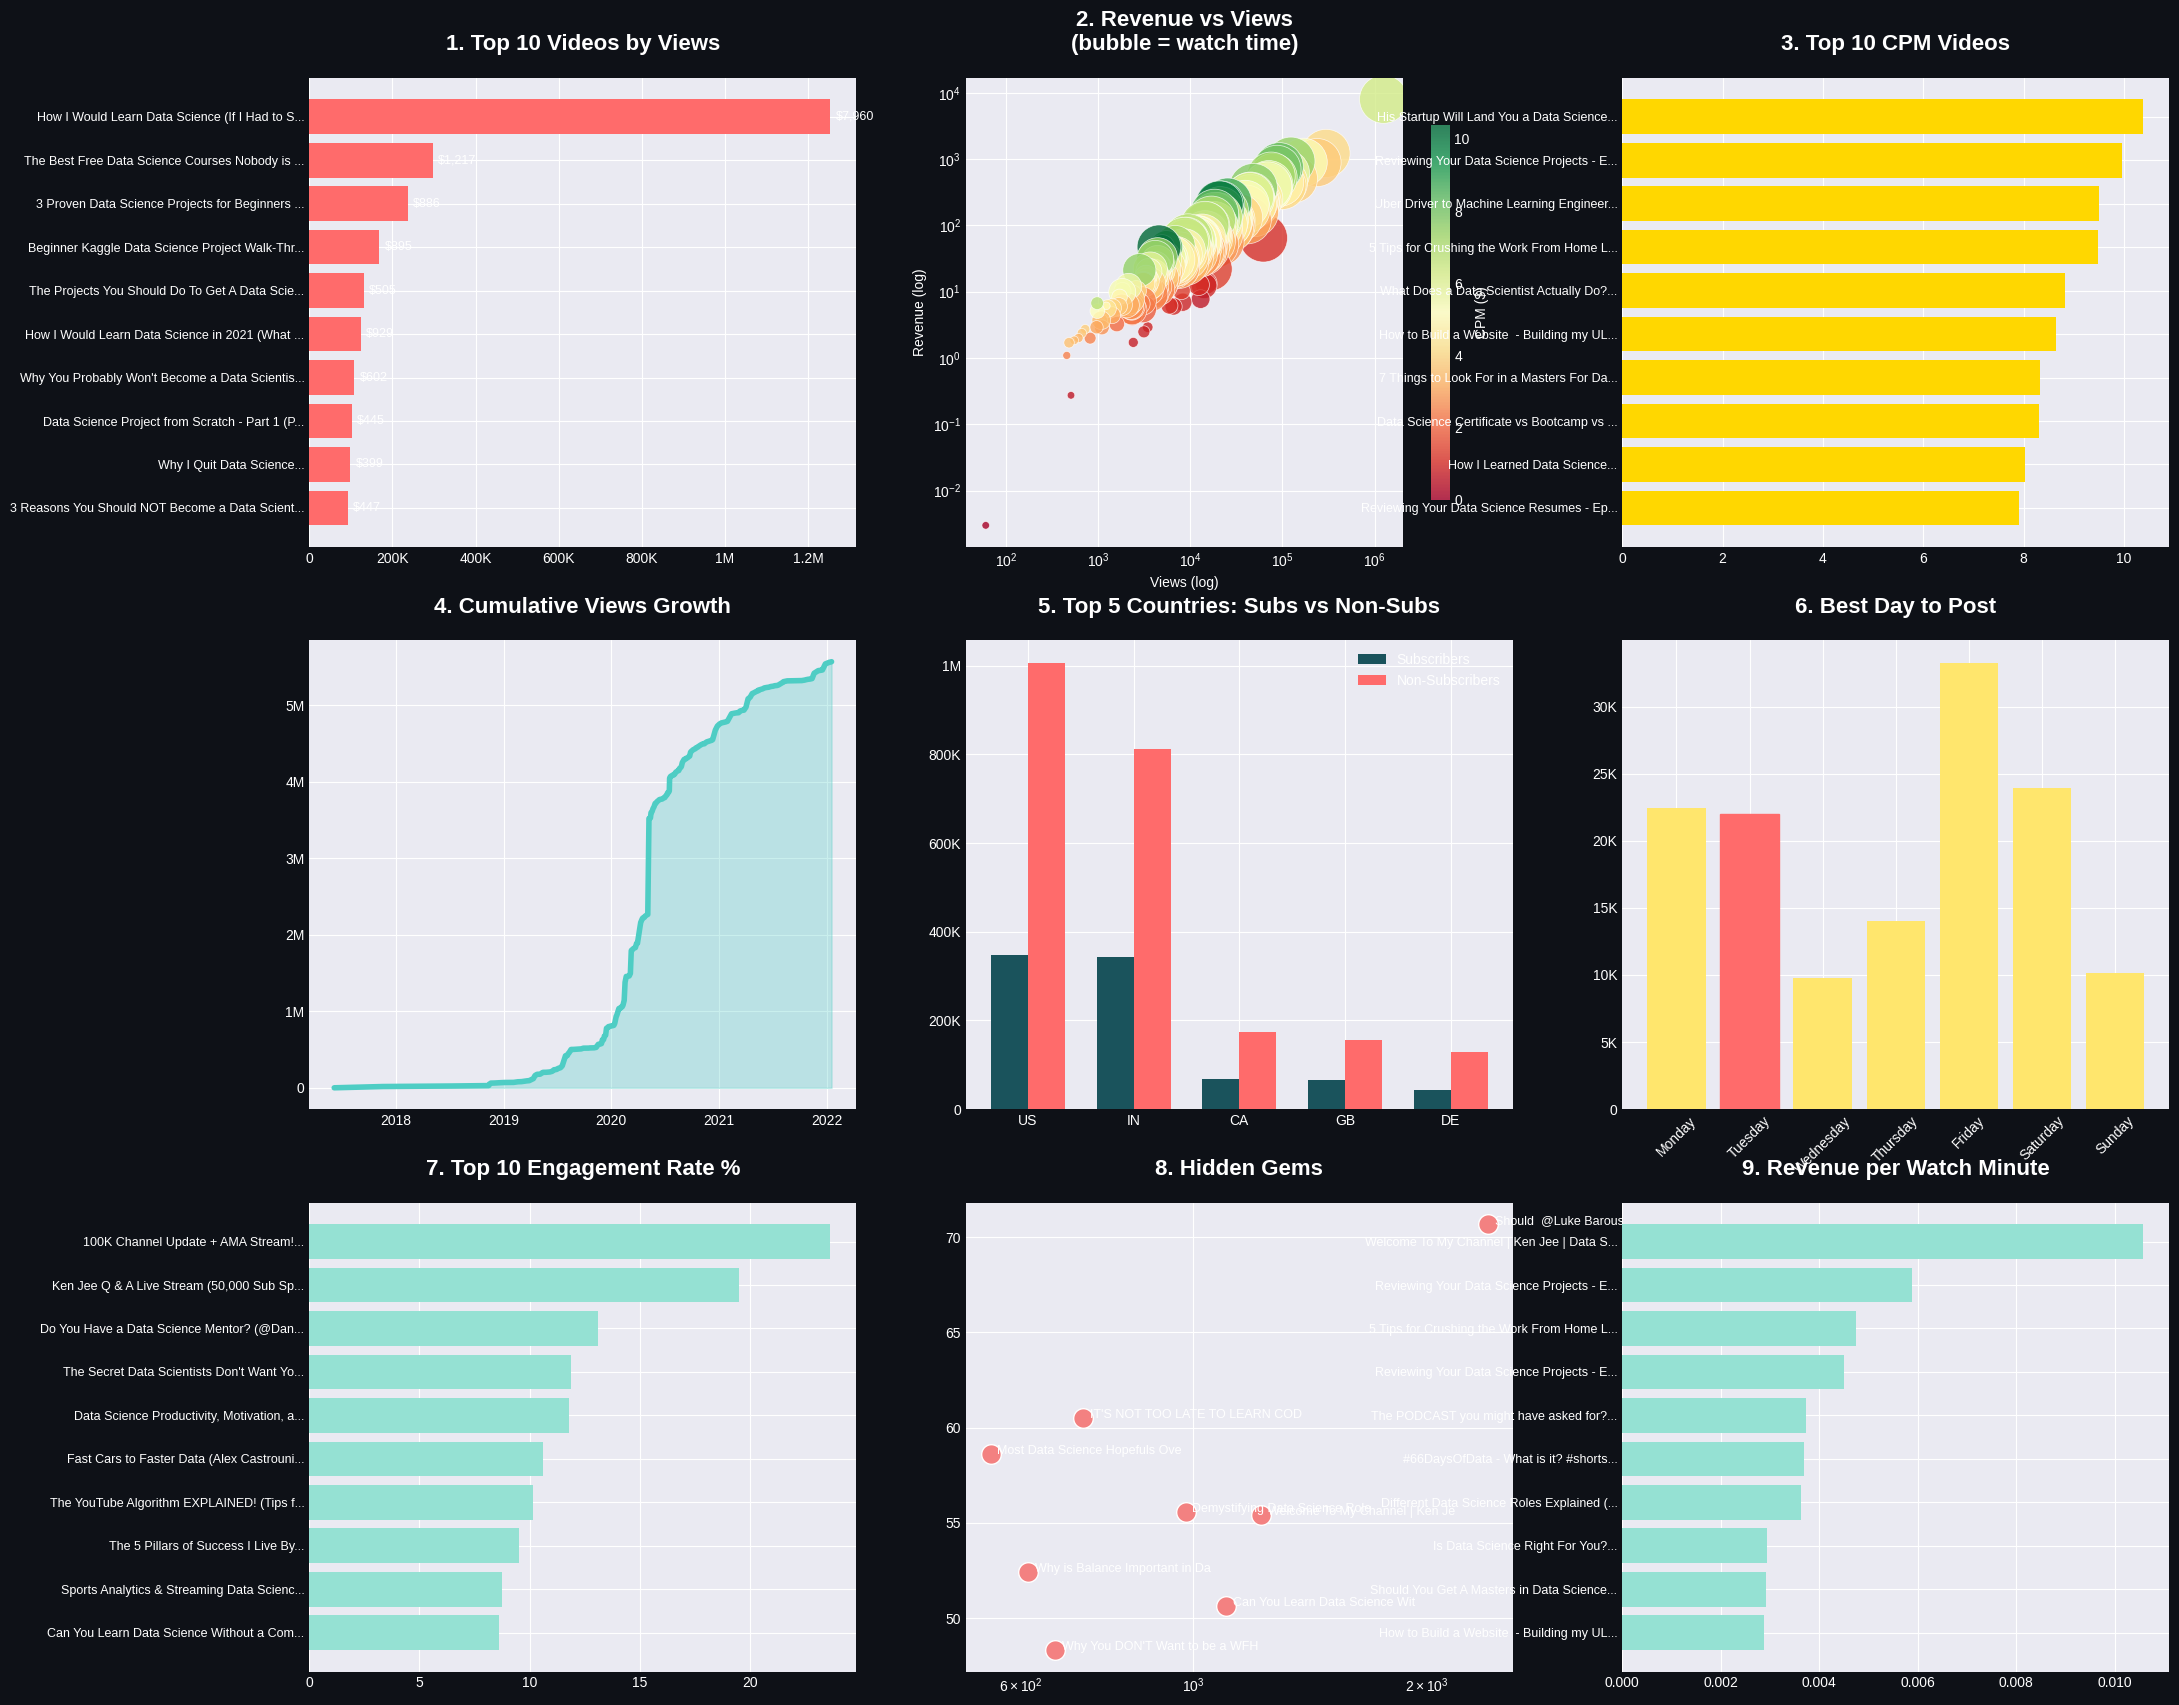

In [ ]:

#DASHBOARD V3


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# 1. LOAD DATA

df = client.query(f"SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.gold_creator_dashboard`").to_dataframe()

perf = client.query(f"""
  SELECT
    DATE(video_publish_date) as date,
    SAFE_CAST(views AS INT64) as views,
    SAFE_CAST(likes AS INT64) as likes,
    SAFE_CAST(comments_added AS INT64) as comments_added,
    SAFE_CAST(watch_time_minutes AS FLOAT64) as watch_time_minutes,
    SAFE_CAST(estimated_revenue_usd AS FLOAT64) as estimated_revenue_usd
  FROM `{PROJECT_ID}.{DATASET_ID}.silver_video_enriched`
""").to_dataframe()

country = client.query(f"""
  SELECT
    country_code,
    is_subscribed,
    SUM(SAFE_CAST(views AS INT64)) as views,
    AVG(SAFE_CAST(average_view_percentage AS FLOAT64)) as avg_pct
  FROM `{PROJECT_ID}.{DATASET_ID}.staging_aggregated_country`
  GROUP BY country_code, is_subscribed
""").to_dataframe()


country['is_subscribed'] = country['is_subscribed'].map({'true': True, 'false': False}).astype(bool)

# 2. CALCULATIONS

df['cpm'] = (df['total_revenue_usd'] / df['total_views']) * 1000
df['engagement_rate'] = (df['total_likes'] + df['total_comments']) / df['total_views']

# 3. DASHBOARD

fig = plt.figure(figsize=(24, 28))
fig.patch.set_facecolor('#0e1117')
plt.rcParams.update({'text.color': 'white', 'axes.labelcolor': 'white',
                     'xtick.color': 'white', 'ytick.color': 'white'})

def human(num):
    num = float('{:.3g}'.format(num))
    mag = 0
    while abs(num) >= 1000:
        mag += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B'][mag])

# 1. TOP 10
ax1 = plt.subplot(4, 3, 1)
top10 = df.head(10).sort_values('total_views', ascending=True)
bars = ax1.barh(range(len(top10)), top10['total_views'], color='#FF6B6B')
ax1.set_yticks(range(len(top10)))
ax1.set_yticklabels([t[:45] + "..." for t in top10['video_title']], fontsize=9)
ax1.set_title("1. Top 10 Videos by Views", fontsize=16, fontweight='bold', pad=20)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, p: human(x)))
for i, (v, r) in enumerate(zip(top10['total_views'], top10['total_revenue_usd'])):
    ax1.text(v + max(top10['total_views'])*0.01, i, f"${r:,.0f}", va='center', fontsize=9)

# 2. BUBBLE CHART
ax2 = plt.subplot(4, 3, 2)
sizes = df['total_watch_minutes'] / 30
sizes = sizes.clip(lower=30, upper=1200)
sc = ax2.scatter(df['total_views'], df['total_revenue_usd'], s=sizes, c=df['cpm'],
                 cmap='RdYlGn', alpha=0.8, edgecolors='white', linewidth=0.5)
plt.colorbar(sc, label='CPM ($)', shrink=0.8)
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Views (log)"); ax2.set_ylabel("Revenue (log)")
ax2.set_title("2. Revenue vs Views\n(bubble = watch time)", fontsize=16, fontweight='bold', pad=20)

# 3. TOP CPM
ax3 = plt.subplot(4, 3, 3)
top_cpm = df.nlargest(10, 'cpm').sort_values('cpm')
ax3.barh(range(len(top_cpm)), top_cpm['cpm'], color='#FFD700')
ax3.set_yticks(range(len(top_cpm)))
ax3.set_yticklabels([t[:40] + "..." for t in top_cpm['video_title']], fontsize=9)
ax3.set_title("3. Top 10 CPM Videos", fontsize=16, fontweight='bold', pad=20)

# 4. GROWTH
ax4 = plt.subplot(4, 3, 4)
daily = perf.groupby('date').sum().reset_index()
ax4.plot(daily['date'], daily['views'].cumsum(), color='#4ECDC4', linewidth=4)
ax4.fill_between(daily['date'], daily['views'].cumsum(), alpha=0.3, color='#4ECDC4')
ax4.set_title("4. Cumulative Views Growth", fontsize=16, fontweight='bold', pad=20)
ax4.yaxis.set_major_formatter(FuncFormatter(lambda x, p: human(x)))

# 5. SUB vs NON-SUB
ax5 = plt.subplot(4, 3, 5)
sub = country[country['is_subscribed']].groupby('country_code')['views'].sum().nlargest(5)
nonsub = country[~country['is_subscribed']].groupby('country_code')['views'].sum().nlargest(5)
x = range(5)
width = 0.35
ax5.bar([i - width/2 for i in x], sub.values, width, label='Subscribers', color='#1A535C')
ax5.bar([i + width/2 for i in x], nonsub.values, width, label='Non-Subscribers', color='#FF6B6B')
ax5.set_xticks(x)
ax5.set_xticklabels(sub.index)
ax5.set_title("5. Top 5 Countries: Subs vs Non-Subs", fontsize=16, fontweight='bold', pad=20)
ax5.legend()
ax5.yaxis.set_major_formatter(FuncFormatter(lambda x, p: human(x)))

# 6. BEST DAY
ax6 = plt.subplot(4, 3, 6)
perf['weekday'] = pd.to_datetime(perf['date']).dt.day_name()
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_views = perf.groupby('weekday')['views'].mean().reindex(day_order)
bars = ax6.bar(day_views.index, day_views.values, color='#FFE66D')
bars[1].set_color('#FF6B6B')  # Tuesday
ax6.set_title("6. Best Day to Post", fontsize=16, fontweight='bold', pad=20)
ax6.tick_params(axis='x', rotation=45)
ax6.yaxis.set_major_formatter(FuncFormatter(lambda x, p: human(x)))

# 7. ENGAGEMENT
ax7 = plt.subplot(4, 3, 7)
top_eng = df.nlargest(10, 'engagement_rate').sort_values('engagement_rate')
ax7.barh(range(len(top_eng)), top_eng['engagement_rate']*100, color='#95E1D3')
ax7.set_yticks(range(len(top_eng)))
ax7.set_yticklabels([t[:40] + "..." for t in top_eng['video_title']], fontsize=9)
ax7.set_title("7. Top 10 Engagement Rate %", fontsize=16, fontweight='bold', pad=20)

# 8. HIDDEN GEMS
ax8 = plt.subplot(4, 3, 8)
df['gem_score'] = df['avg_view_percentage'].rank(pct=True) - df['total_views'].rank(pct=True)
gems = df.nlargest(8, 'gem_score')
ax8.scatter(gems['total_views'], gems['avg_view_percentage'], s=200, c='#F38181', edgecolors='white')
for i, r in gems.iterrows():
    ax8.text(r['total_views']*1.02, r['avg_view_percentage'], r['video_title'][:30], fontsize=9)
ax8.set_xscale('log')
ax8.set_title("8. Hidden Gems", fontsize=16, fontweight='bold', pad=20)

# 9. REVENUE/MIN
ax9 = plt.subplot(4, 3, 9)
df['rev_per_min'] = df['total_revenue_usd'] / (df['total_watch_minutes'] + 1)
top_rev = df.nlargest(10, 'rev_per_min').sort_values('rev_per_min')
ax9.barh(range(len(top_rev)), top_rev['rev_per_min'], color='#95E1D3')
ax9.set_yticks(range(len(top_rev)))
ax9.set_yticklabels([t[:40] + "..." for t in top_rev['video_title']], fontsize=9)
ax9.set_title("9. Revenue per Watch Minute", fontsize=16, fontweight='bold', pad=20)



print("DASHBOARD LOADED ")

In [ ]:
''' # run this in big query
-- 1. WHAT YOUR DASHBOARD SEES (THIS IS WHAT MATTERS)
SELECT
  video_id,
  video_title
FROM `even-blueprint-441418-p2.media_analytics.dim_video`
WHERE video_id = '4OZip0cgOho'
  AND is_current = TRUE
  or

  -- 2. WHAT BIGQUERY CONSOLE SHOWS BY DEFAULT (ALL HISTORY)
SELECT * FROM `even-blueprint-441418-p2.media_analytics.dim_video`
WHERE video_id = '4OZip0cgOho'
ORDER BY effective_from DESC '''